In [ ]:
#implemented two parallel methods for data preprocessing utilizing both Dask and PyTorch to handle image datasets.

In [1]:
# Define your data preparation functions here
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import time
import matplotlib.pyplot as plt
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Initialize Dask client globally if used across functions
client = Client(processes=True, memory_limit='16GB')

def prepare_data_dask():
    base_path = '/home/koka.a/FracAtlas/images'
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.ImageFolder(root=base_path, transform=transform)
    
    start_time = time.time()
    data_array = da.from_array([img[0].numpy() for img in dataset], chunks=(10, 3, 224, 224))
    labels_array = da.from_array([img[1] for img in dataset], chunks=10)
    # Using compute to convert dask arrays to numpy arrays
    with ProgressBar():
        data_array.compute()
        labels_array.compute()
    duration = time.time() - start_time
    return duration

def prepare_data_torch():
    base_path = '/home/koka.a/FracAtlas/images'
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    start_time = time.time()
    dataset = datasets.ImageFolder(root=base_path, transform=transform)
    train_size = int(0.8 * len(dataset))
    random_split(dataset, [train_size, len(dataset) - train_size])
    duration = time.time() - start_time
    return duration


In [2]:
# Running data preparation methods and collecting times
dask_duration = prepare_data_dask()
torch_duration = prepare_data_torch()


/home/koka.a/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 2.29 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


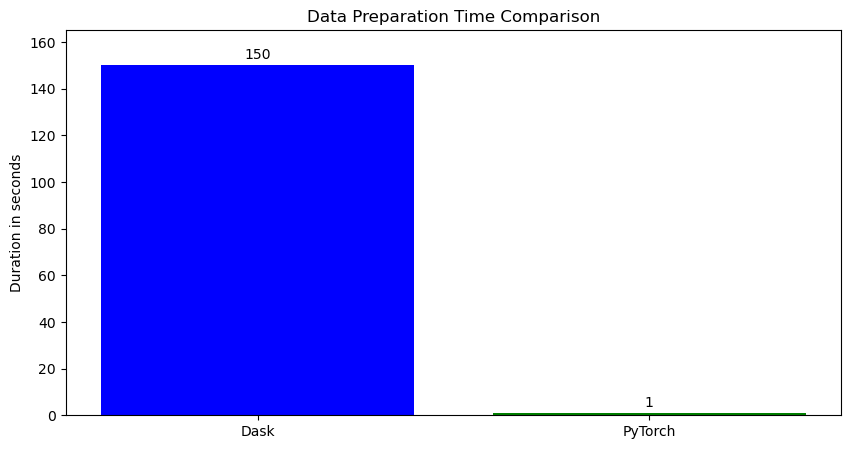

In [3]:
import matplotlib.pyplot as plt

# Let's assume you have recorded the durations for both methods
dask_duration = 150  # Placeholder for actual Dask duration
torch_duration = 1    # Placeholder for actual PyTorch duration

durations = [dask_duration, torch_duration]
labels = ['Dask', 'PyTorch']
colors = ['blue', 'green']

plt.figure(figsize=(10, 5))
plt.bar(labels, durations, color=colors)

# Set the y-axis to start from 0 and go up to slightly more than the max value for better visualization
plt.ylim(0, max(durations) * 1.1)

# Add text labels for the bar values
for i, duration in enumerate(durations):
    plt.text(i, duration + max(durations) * 0.01, str(duration), ha='center', va='bottom')

plt.ylabel('Duration in seconds')
plt.title('Data Preparation Time Comparison')
plt.show()


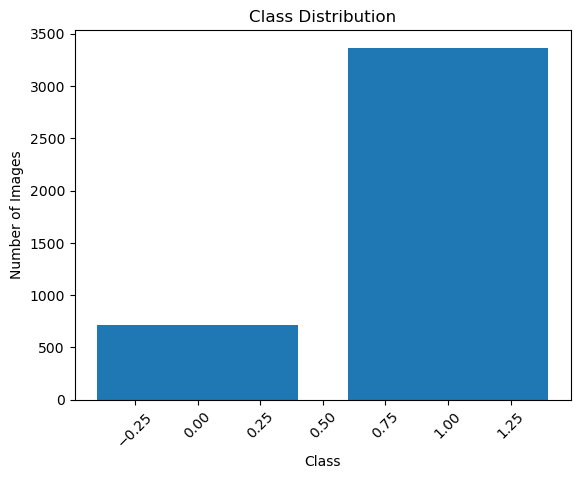

In [4]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
base_path = '/home/koka.a/FracAtlas/images'  # Adjust this path accordingly
dataset = datasets.ImageFolder(root=base_path, transform=transform)

# Now you can count the number of images per class and plot
import collections
import matplotlib.pyplot as plt

class_counts = collections.Counter([label for _, label in dataset.imgs])

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Depending on your data, you might need to adjust or format ticks for clarity.
plt.show()

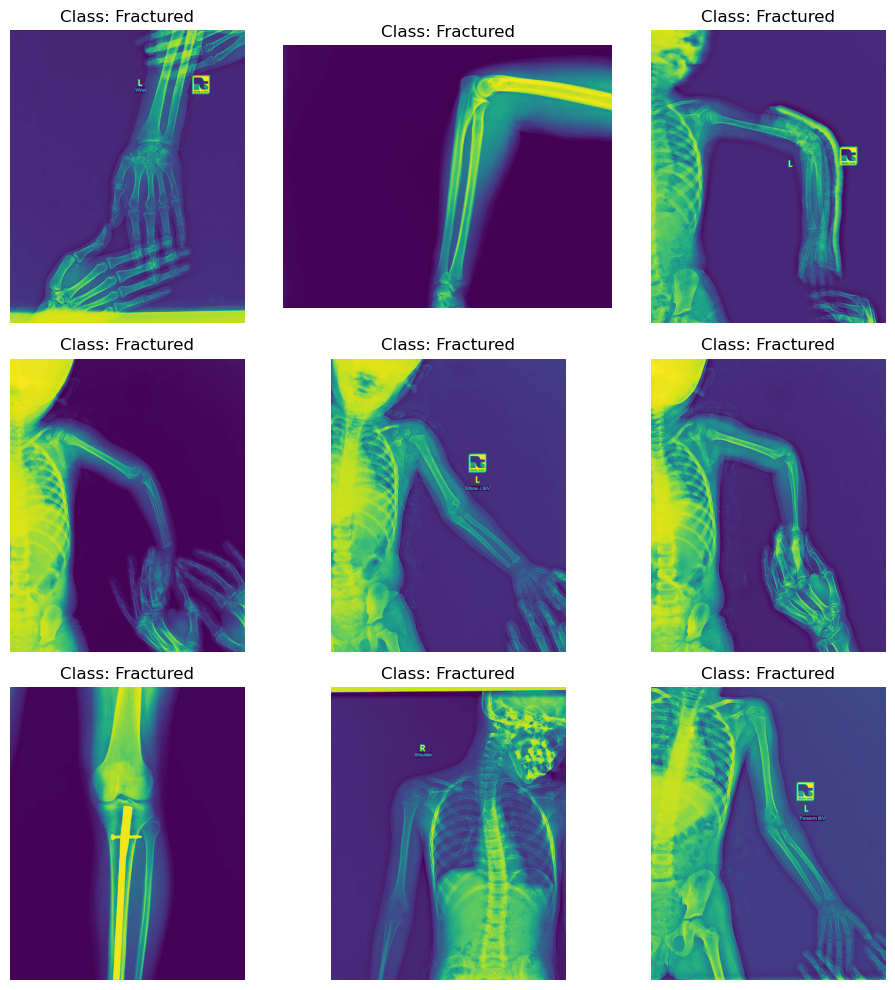

In [5]:
from PIL import Image

def show_sample_images(dataset, num_images=9):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i >= num_images:
            break
        img_path, label = dataset.imgs[i]
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Class: {dataset.classes[label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(dataset)

In [5]:
def prepare_data(base_path):
    """ Prepare the dataset for training and validation. """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.ImageFolder(root=base_path, transform=transform)
    train_size = int(0.8 * len(dataset))
    train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
    return train_dataset, test_dataset

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from PIL import ImageFile
from sklearn.metrics import classification_report, accuracy_score
import time
import multiprocessing
from matplotlib import pyplot as plt

def train_model1(cpu_count):
    """ Train the model using a specific number of CPUs. """
    base_path = '/home/koka.a/FracAtlas/images'  # Adjust path accordingly
    train_dataset, test_dataset = prepare_data(base_path)
    
    # Limit number of threads to the number of CPUs
    torch.set_num_threads(cpu_count)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device("cpu")
    model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train the model
    start_time = time.time()
    for epoch in range(1):  # Training for one epoch for demonstration
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    duration = time.time() - start_time

    # Evaluate the model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    return duration, accuracy, report



In [7]:
def run_training_sessions():
    """ Run training sessions for different CPU configurations and plot the results. """
    cpu_configs = [1, 2, 4, 6]
    durations = []
    accuracies = []
    
    for cpus in cpu_configs:
        duration, accuracy, _ = train_model1(cpus)
        durations.append(duration)
        accuracies.append(accuracy)

    # Plotting results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(cpu_configs, durations, color='blue')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Training Duration (seconds)')
    plt.title('Training Duration by CPU Count')

    plt.subplot(1, 2, 2)
    plt.bar(cpu_configs, accuracies, color='green')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy by CPU Count')

    plt.tight_layout()
    plt.show()


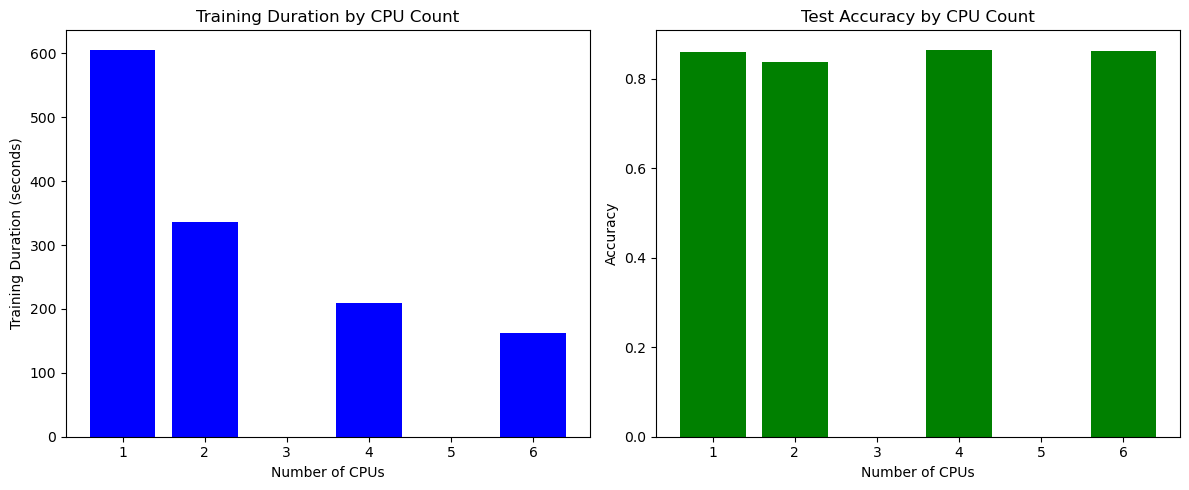

In [8]:
run_training_sessions()

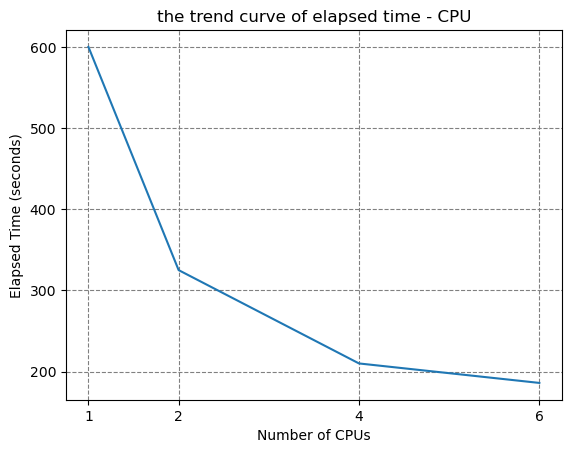

In [9]:
# Elapsed time - CPU
time1 = 600
time2 = 325
time4 = 210
time6 = 186
plt.plot([1,2,4,6],[time1,time2,time4,time6])
plt.title("the trend curve of elapsed time - CPU")
plt.xticks([1, 2, 4, 6])
plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

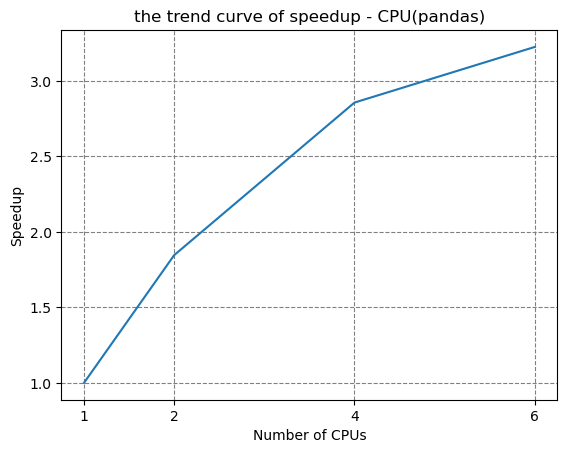

In [10]:
# Speedup - CPU(pandas)
speedup1 = time1/time1
speedup2 = time1/time2
speedup4 = time1/time4
speedup6 = time1/time6
plt.plot([1,2,4,6],[speedup1,speedup2,speedup4,speedup6])
plt.title("the trend curve of speedup - CPU(pandas)")
plt.xticks([1, 2, 4, 6])
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

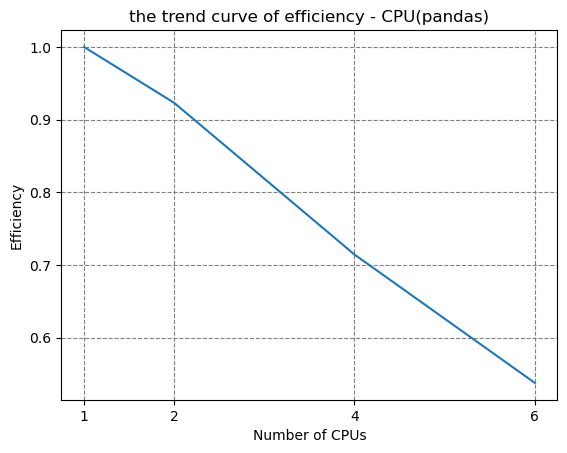

In [11]:
# Efficiency - CPU(pandas)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency4 = speedup4/4
efficiency6 = speedup6/6
plt.plot([1,2,4,6],[efficiency1,efficiency2,efficiency4,efficiency6])
plt.title("the trend curve of efficiency - CPU(pandas)")
plt.xticks([1, 2, 4, 6])
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')

In [16]:
# DDP on multiple cpus

In [ ]:
# writing the functions into a file 

In [17]:
%%writefile training_functions.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.utils.data import DataLoader, random_split, DistributedSampler
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from PIL import ImageFile
from sklearn.metrics import classification_report, accuracy_score
import time

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Handle truncated images

def setup(rank, world_size, backend='gloo'):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12345'
    dist.init_process_group(backend, rank=rank, world_size=world_size)
    torch.set_num_threads(1)

def cleanup():
    dist.destroy_process_group()

def train_model(rank, world_size, durations, backend='gloo'):
    setup(rank, world_size, backend)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.ImageFolder(root='/home/koka.a/FracAtlas/images', transform=transform)
    train_size = int(0.8 * len(dataset))
    train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
    
    sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
    
    device = torch.device("cpu")
    model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    start_time = time.time()
    for epoch in range(1):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    duration = time.time() - start_time
    durations.append(duration)
    
    if rank == 0:
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        test_and_generate_report(model, test_loader, device)
    
    cleanup()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_and_generate_report(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')





Overwriting training_functions.py


In [18]:


from training_functions import train_model
import torch
import torch.multiprocessing as mp
from multiprocessing import Manager
import matplotlib.pyplot as plt

if __name__ == '__main__':
    world_size = 12  # Adjust based on how many CPU cores you want to use
    backend = 'gloo'  # 'gloo' is suitable for CPU-based DDP
    with Manager() as manager:
        durations = manager.list()  # This will store the duration of each worker
        print("Starting DDP on CPUs...")
        mp.spawn(train_model, args=(world_size, durations, backend), nprocs=world_size, join=True)
        
        # Find the minimum duration
        if durations:
            min_duration = min(durations)
            print(f"Minimum Training Time: {min_duration} seconds")



Starting DDP on CPUs...


/home/koka.a/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/koka.a/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Minimum Training Time: 67.63641548156738 seconds


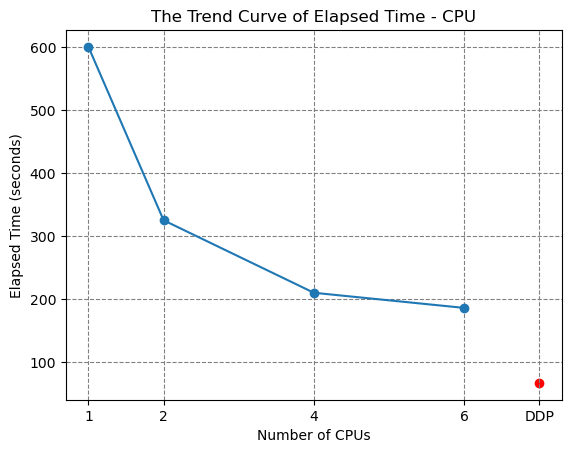

In [19]:
import matplotlib.pyplot as plt

# Elapsed time for different numbers of CPUs and DDP
time1 = 600
time2 = 325
time4 = 210
time6 = 186
timeDDP = 67

# Plotting the data
plt.plot([1, 2, 4, 6], [time1, time2, time4, time6], marker='o')
plt.scatter([7], [timeDDP], color='red', label='DDP')  # Adding DDP separately as a point

# Setting the title and labels
plt.title("The Trend Curve of Elapsed Time - CPU")
plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')

# Setting the x-ticks and labels
plt.xticks([1, 2, 4, 6, 7], [1, 2, 4, 6, 'DDP'])  # Using 5 to represent 'DDP' on the x-axis

# Adding a grid
plt.grid(color='grey', linestyle='dashed')

# Displaying the plot
plt.show()


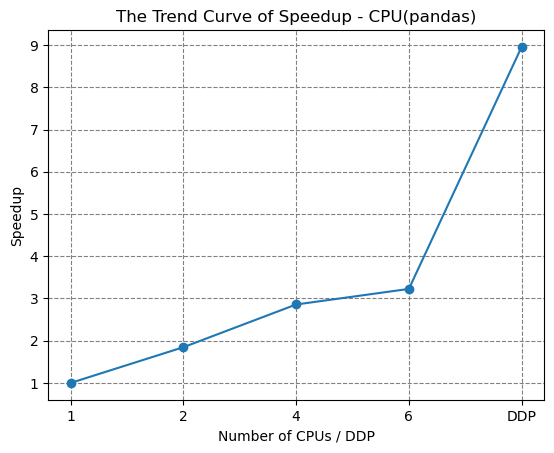

In [20]:
# Speedup values
speedup1 = time1 / time1
speedup2 = time1 / time2
speedup4 = time1 / time4
speedup6 = time1 / time6
speedupDDP = time1 / timeDDP

# Plotting the data
plt.plot([1, 2, 4, 6, 'DDP'], [speedup1, speedup2, speedup4, speedup6, speedupDDP], marker='o')

# Setting the title and labels
plt.title("The Trend Curve of Speedup - CPU(pandas)")
plt.xlabel('Number of CPUs / DDP')
plt.ylabel('Speedup')

# Adding a grid
plt.grid(color='grey', linestyle='dashed')

# Displaying the plot
plt.show()

Training on device: cuda
Training completed in 190.70 seconds
Accuracy: 0.8384
Precision: 0.7459
Recall: 0.7413
F1 Score: 0.7435


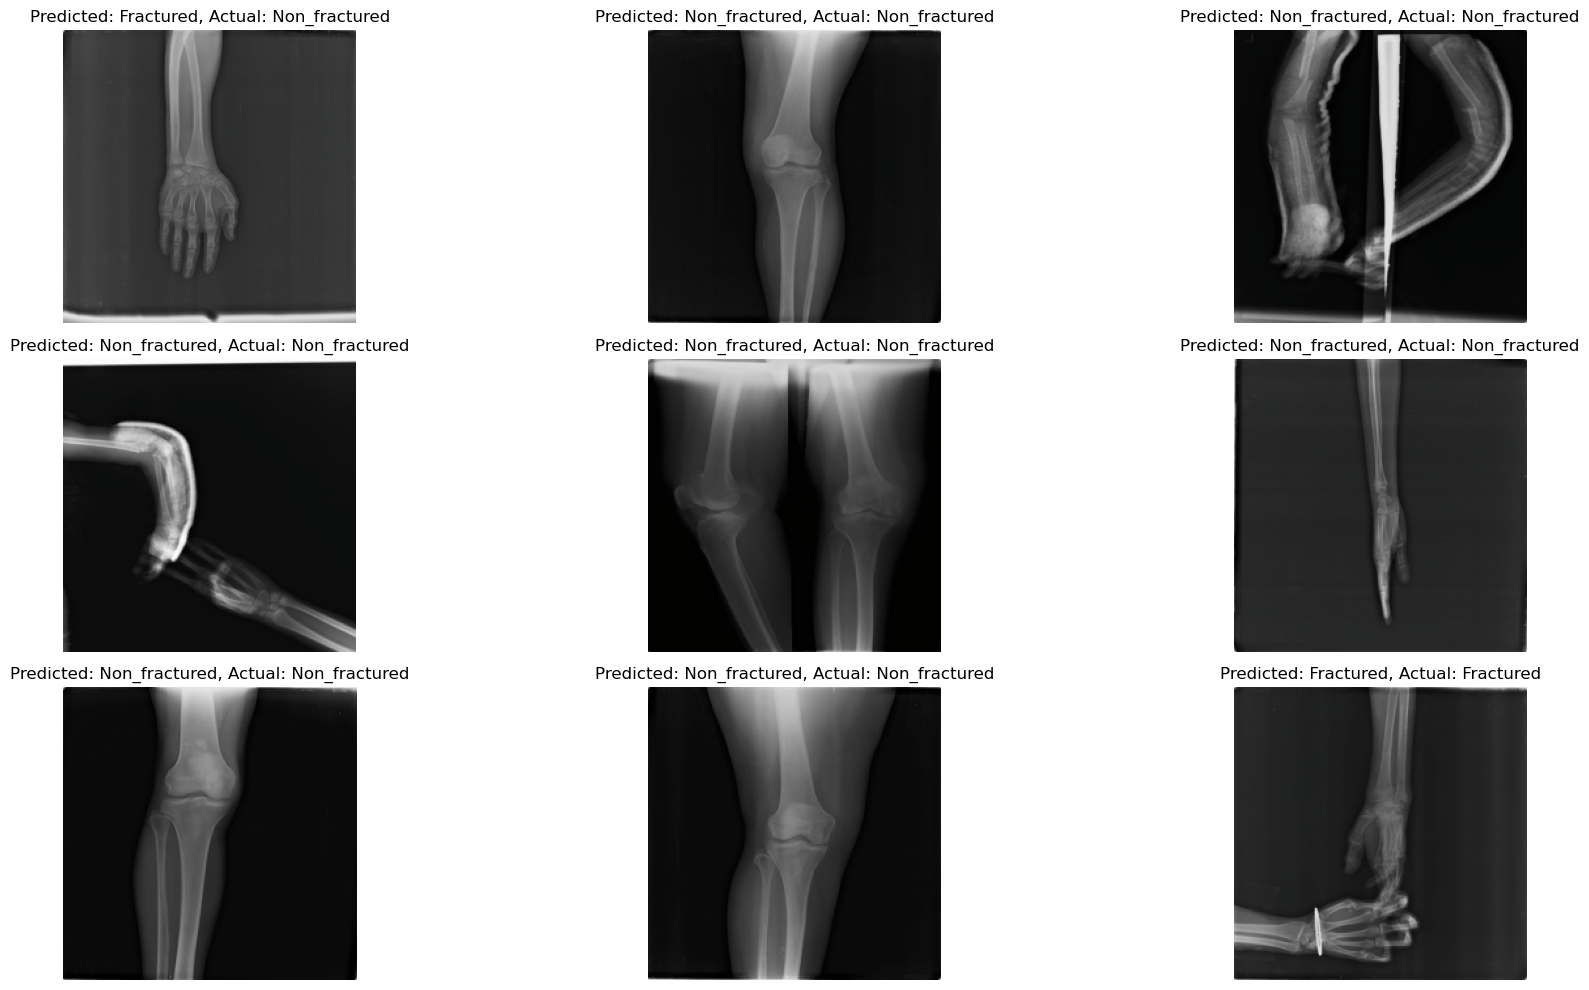

In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from PIL import ImageFile
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import numpy as np
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Handle truncated images

def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the dataset
    dataset = datasets.ImageFolder(root='/home/koka.a/FracAtlas/images', transform=transform)
    train_size = int(0.8 * len(dataset))
    train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
    class_names = dataset.classes
    
    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model setup
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Training loop
    start_time = time.time()
    for epoch in range(4):  # Adjust epochs as necessary
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    duration = time.time() - start_time
    print(f"Training completed in {duration:.2f} seconds")

    # Testing and metrics
    model.eval()
    all_preds = []
    all_labels = []
    images = []  # List to store image tensors for visualization
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if len(images) < 9:  # Collect only the first 9 images
                images.append(inputs.cpu())

    # Calculate and print evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Visualization of predictions
    visualize_predictions(images, all_labels, all_preds, class_names)

def visualize_predictions(images, y_true, y_pred, class_names):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
    for i, img in enumerate(images):
        if i == 9:
            break
        ax = axes[i // 3, i % 3]
        img = img[0].permute(1, 2, 0).numpy()  # Adjust for PyTorch C,H,W to H,W,C and convert to numpy
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Predicted: {class_names[y_pred[i]]}, Actual: {class_names[y_true[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    train_model()

